<a href="https://colab.research.google.com/github/byunsy/pneumonia-classification/blob/main/Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Classification on Patient Chest X-Ray Images

---



## 01. Import Necessary Packages
We first need to import several packages. We will be using TensorFlow and Keras.

In [1]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 02. Attain Dataset from Kaggle

Firstly, pip install kaggle.

In [3]:
!pip install -q kaggle

Also import google.colab to upload the kaggle.json file which can be downloaded manually from your kaggle account.

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sangyoonbyun","key":"ad4b5a5e485cc011a17e7df7e3010c80"}'}

Make a new directory and copy the kaggle.json file to that directory. This is required to download datasets.

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

Make some changes to the permission settings.

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

Download the desired datasets. It is easy if you go to the dataset, and click the additional setting (three dots) and "copy API command".

In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:51<00:00, 35.5MB/s]
100% 2.29G/2.29G [01:51<00:00, 22.0MB/s]


Now unzip the downloaded zip folder.

In [8]:
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

Delete some unnecessary folders and files from unzipped directory.

In [9]:
!rm -r /content/chest_xray/__MACOSX/
!rm -r /content/chest_xray/chest_xray/

## 03. Understanding the Dataset

Firstly, create directory paths for the base directory and its main subdirectories.

In [10]:
# Create directory paths
base_dir = os.path.join(os.path.dirname('/content/chest-xray-pneumonia.zip'), 'chest_xray')

test_dir  = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')

Now, let's learn more about the number of images in each directory.

In [11]:
# Number of images
num_ts_norm = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
num_ts_pneu = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
num_ts = num_ts_norm + num_ts_pneu

num_tr_norm = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_tr_pneu = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_tr = num_tr_norm + num_tr_pneu

num_vl_norm = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
num_vl_pneu = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
num_vl = num_vl_norm + num_vl_pneu

# Display number of images in each directory
print("TOTAL NUMBER OF TEST IMAGES:", num_ts)
print("Number of NORMAL    - TEST :", num_ts_norm)
print("Number of PNEUMONIA - TEST :", num_ts_pneu, "\n")

print("TOTAL NUMBER OF TRAIN IMAGES:", num_tr)
print("Number of NORMAL    - TRAIN :", num_tr_norm)
print("Number of PNEUMONIA - TRAIN :", num_tr_pneu, "\n")

print("TOTAL NUMBER OF VALIDATION IMAGES:", num_vl)
print("Number of NORMAL    - VALIDATION :", num_vl_norm)
print("Number of PNEUMONIA - VALIDATION :", num_vl_pneu, "\n")

print("-"*30)
print("NORMAL IMAGES   :", num_ts_norm + num_tr_norm + num_vl_norm)
print("PNEUMONIA IMAGES:", num_ts_pneu + num_tr_pneu + num_vl_pneu)


TOTAL NUMBER OF TEST IMAGES: 624
Number of NORMAL    - TEST : 234
Number of PNEUMONIA - TEST : 390 

TOTAL NUMBER OF TRAIN IMAGES: 5216
Number of NORMAL    - TRAIN : 1341
Number of PNEUMONIA - TRAIN : 3875 

TOTAL NUMBER OF VALIDATION IMAGES: 16
Number of NORMAL    - VALIDATION : 8
Number of PNEUMONIA - VALIDATION : 8 

------------------------------
NORMAL IMAGES   : 1583
PNEUMONIA IMAGES: 4273


Notice that we only have **16** validation images and over **5,216** training images. To get a less extreme division in the dataset, we will first append the two sets together and then randomly split them into training and validation sets with 80:20 ratio. 

It is important to note that we also have some imbalance in the number of normal and pneumonia images. To handle this issue, we will create class weights which we will later use in the model training process.

## 04. Data Preprocessing

In [12]:
# Move the images to corresponding directories (from val to train)
!mv /content/chest_xray/val/NORMAL/* /content/chest_xray/train/NORMAL/
!mv /content/chest_xray/val/PNEUMONIA/* /content/chest_xray/train/PNEUMONIA/

Check if the files have moved.

In [13]:
# Number of images
num_tr_norm = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_tr_pneu = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_tr = num_tr_norm + num_tr_pneu

num_vl_norm = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
num_vl_pneu = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
num_vl = num_vl_norm + num_vl_pneu

# Display
print("TOTAL NUMBER OF TRAIN IMAGES:", num_tr)
print("Number of NORMAL    - TRAIN :", num_tr_norm)
print("Number of PNEUMONIA - TRAIN :", num_tr_pneu, "\n")

print("TOTAL NUMBER OF VALIDATION IMAGES:", num_vl)
print("Number of NORMAL    - VALIDATION :", num_vl_norm)
print("Number of PNEUMONIA - VALIDATION :", num_vl_pneu, "\n")

TOTAL NUMBER OF TRAIN IMAGES: 5232
Number of NORMAL    - TRAIN : 1349
Number of PNEUMONIA - TRAIN : 3883 

TOTAL NUMBER OF VALIDATION IMAGES: 0
Number of NORMAL    - VALIDATION : 0
Number of PNEUMONIA - VALIDATION : 0 



We can see that we have successfully moved all the validation images to the training directory. We will now properly split the dataset using train_test_split() from sklearn.

In [14]:
# Get a list of all the filenames in the train directory
files = glob.glob("/content/chest_xray/train/*/*")

# Randomly shuffle and split the files into two sets (lists) in 80:20 ratio
train_files, val_files = train_test_split(files, test_size=0.2)

# Number of training and validation images
NUM_TRAIN = len(train_files)
NUM_VALIDATION = len(val_files)

print("TRAIN     :", NUM_TRAIN)
print("VALIDATION:", NUM_VALIDATION)

TRAIN     : 4185
VALIDATION: 1047


We now have a proper split between training and validation sets. 

Let's create a function to identify the label of an image and count the number of **NORMAL** and **PNEUMONIA** images in the training set.

In [17]:
# Parses the filename and determines whether it is in normal or pneumonia class
# Returns True or 1 if it is PNEU. False or 0 if it is NORM (not PNEU)
def get_label(filename):
  label = filename.split(os.path.sep)[-2]
  return label == 'PNEUMONIA'

# Counter
NUM_NORM = 0
NUM_PNEU = 0

# Iterate through each file and increment accordingly
for file in train_files:
  if get_label(file):
    NUM_PNEU += 1
  else:
    NUM_NORM += 1

print("NORMAL    in TRAINING:", NUM_NORM)
print("PNEUMONIA in TRAINING:", NUM_PNEU)

NORMAL    in TRAINING: 1087
PNEUMONIA in TRAINING: 3098


Organize these newly split training and validation sets in correct directories. 

In [18]:
# For each file, determine its label(NORM or PNEU) and move it to its
# corresponding directory. 
# If it is already in the correct directory, then do nothing (pass).

for file in train_files:
  try:
    if get_label(file):
      shutil.move(file, os.path.join(train_dir, 'PNEUMONIA'))
    else:
      shutil.move(file, os.path.join(train_dir, 'NORMAL'))
  except:
    pass

for file in val_files:
  try:
    if get_label(file):
      shutil.move(file, os.path.join(val_dir, 'PNEUMONIA'))
    else:
      shutil.move(file, os.path.join(val_dir, 'NORMAL'))
  except: 
    pass

Check if we have done so successfully and accurately.

In [19]:
# Number of images
num_tr_norm = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_tr_pneu = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_tr = num_tr_norm + num_tr_pneu

num_vl_norm = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
num_vl_pneu = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
num_vl = num_vl_norm + num_vl_pneu

# Display
print("TOTAL NUMBER OF TRAIN IMAGES:", num_tr)
print("Number of NORMAL    - TRAIN :", num_tr_norm)
print("Number of PNEUMONIA - TRAIN :", num_tr_pneu, "\n")

print("TOTAL NUMBER OF VALIDATION IMAGES:", num_vl)
print("Number of NORMAL    - VALIDATION :", num_vl_norm)
print("Number of PNEUMONIA - VALIDATION :", num_vl_pneu, "\n")

TOTAL NUMBER OF TRAIN IMAGES: 4185
Number of NORMAL    - TRAIN : 1087
Number of PNEUMONIA - TRAIN : 3098 

TOTAL NUMBER OF VALIDATION IMAGES: 1047
Number of NORMAL    - VALIDATION : 262
Number of PNEUMONIA - VALIDATION : 785 



Let's now deal with the imbalance in the number of normal and pneumonia images in training set using class weights. This dictionary of class weights will be used later on. 

According to TF documentations, class weights "can be useful to tell the model to "pay more attention" to samples from an under-represented class." (https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

In [20]:
# Compute class weights for normal and pneumonia images
weight_norm = (1 / NUM_NORM)*(NUM_TRAIN)/2.0 
weight_pneu = (1 / NUM_PNEU)*(NUM_TRAIN)/2.0

# Create a dictionary to store the weights
class_weight = {0: weight_norm, 1: weight_pneu}

print('Weight for NORMAL    (class 0): {:.2f}'.format(weight_norm))
print('Weight for PNEUMONIA (class 1): {:.2f}'.format(weight_pneu))

Weight for NORMAL    (class 0): 1.93
Weight for PNEUMONIA (class 1): 0.68


## 05. Data Augmentation


We will be using a batch size of 32 and image size of 200x200. 

In [21]:
BATCH_SIZE = 100
IMG_SHAPE = 200

Create a function that will display images.

In [22]:
# This function will plot images in the form of a grid with 1 row and 5 columns 
# where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Applying Horizontal Flip

We use ImageDataGenerator to rescale the images by 255 and then apply a random horizontal flip.

Found 4185 images belonging to 2 classes.


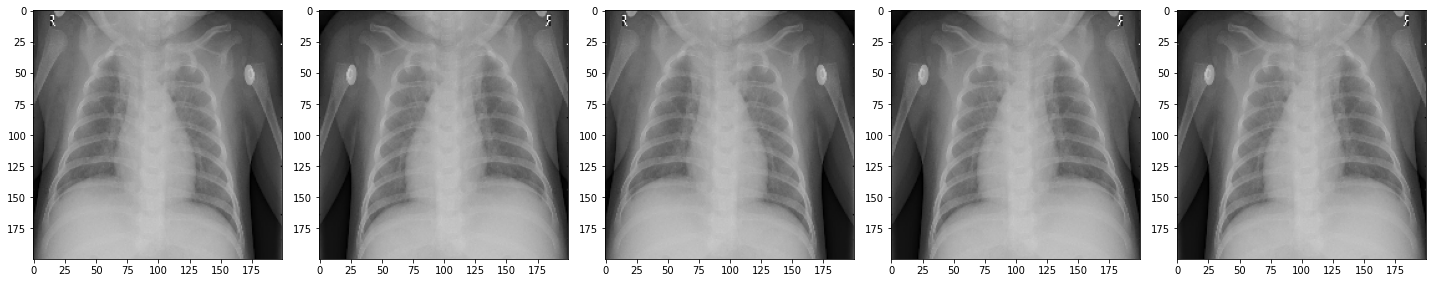

In [24]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Applying Rotation

We use ImageDataGenerator to rescale the images by 255 and then apply a random rotation.

Found 4185 images belonging to 2 classes.


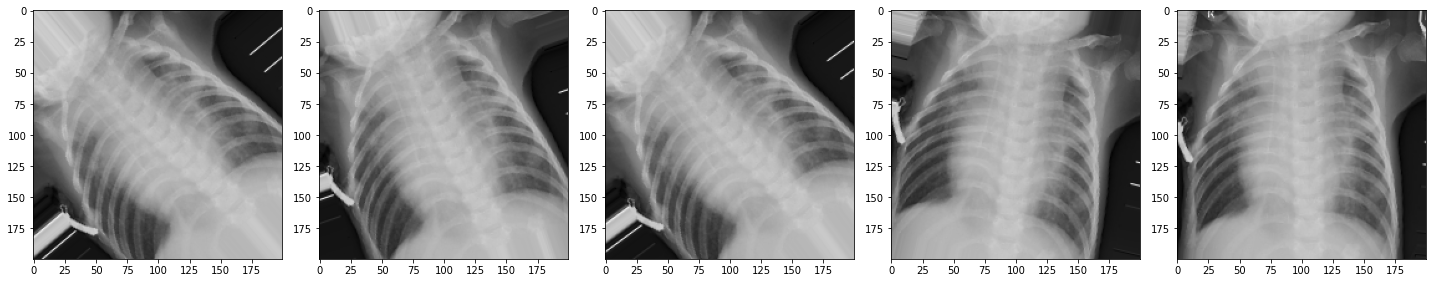

In [25]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Applying Zoom

We use ImageDataGenerator to rescale the images by 255 and then apply a random zoom.

Found 4185 images belonging to 2 classes.


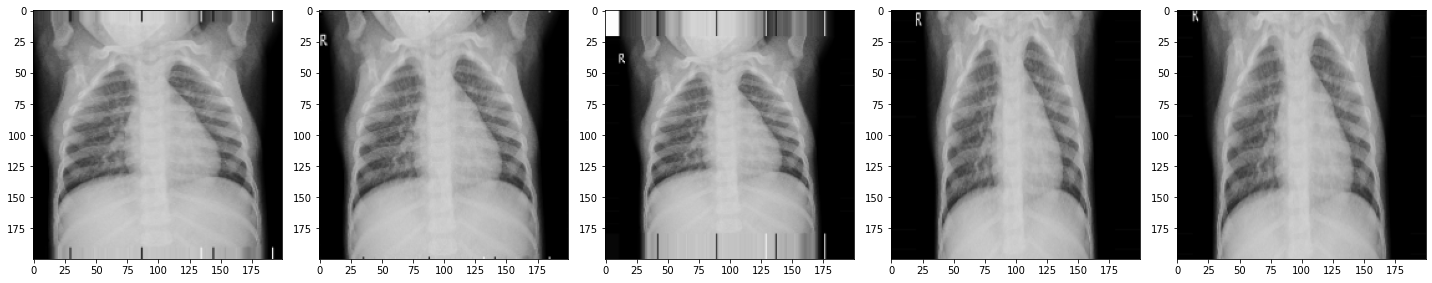

In [26]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.25)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True, 
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Combining the Transformations

Preparing data for training images.

Found 4185 images belonging to 2 classes.


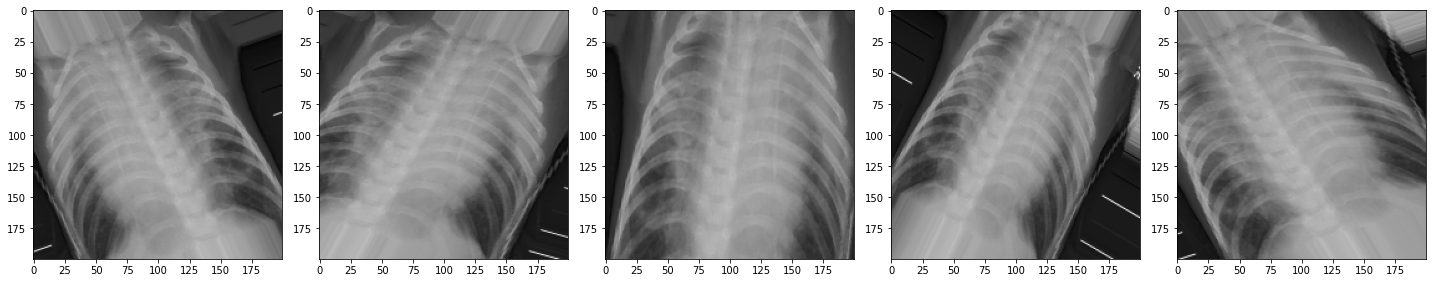

In [27]:
image_gen_train = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=45,
    zoom_range=0.25,
    horizontal_flip=True, 
    width_shift_range=0.05,
    height_shift_range=0.05
)

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True, 
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Preparing data for validation images.

In [28]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE,IMG_SHAPE),
                                                 class_mode='binary')

Found 1047 images belonging to 2 classes.


## 05. Creating a CNN Model

The genereal structure is as follows:

* Three pairs of convolution and max-pooling layers
   - 16, 32, and 62 nodes in that order
   - Same Padding
   - ReLU Activation
* Flatten
* Two Dense layers
    - 512 and 2 nodes in that order
    - ReLU Activation for the first dense layer
    - Dropout rate at 0.2 at each dense layer


In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])

## 06. Compiling the CNN Model

In [30]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 07. Training the CNN Model

In [31]:
epochs = 20

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE))),
    class_weight=class_weight,
)

Epoch 1/20
42/42 [==============================] - 79s 2s/step - loss: 0.7160 - accuracy: 0.6416 - val_loss: 0.3170 - val_accuracy: 0.8720
Epoch 2/20
42/42 [==============================] - 79s 2s/step - loss: 0.3466 - accuracy: 0.8459 - val_loss: 0.4914 - val_accuracy: 0.7994
Epoch 3/20
42/42 [==============================] - 79s 2s/step - loss: 0.3254 - accuracy: 0.8547 - val_loss: 0.4990 - val_accuracy: 0.7813
Epoch 4/20
42/42 [==============================] - 79s 2s/step - loss: 0.3061 - accuracy: 0.8600 - val_loss: 0.3005 - val_accuracy: 0.8653
Epoch 5/20
42/42 [==============================] - 79s 2s/step - loss: 0.2603 - accuracy: 0.8863 - val_loss: 0.4008 - val_accuracy: 0.8166
Epoch 6/20
42/42 [==============================] - 79s 2s/step - loss: 0.2572 - accuracy: 0.8891 - val_loss: 0.3002 - val_accuracy: 0.8816
Epoch 7/20
42/42 [==============================] - 78s 2s/step - loss: 0.2809 - accuracy: 0.8738 - val_loss: 0.2129 - val_accuracy: 0.9112
Epoch 8/20
42/42 [==

## 08. Displaying the Results

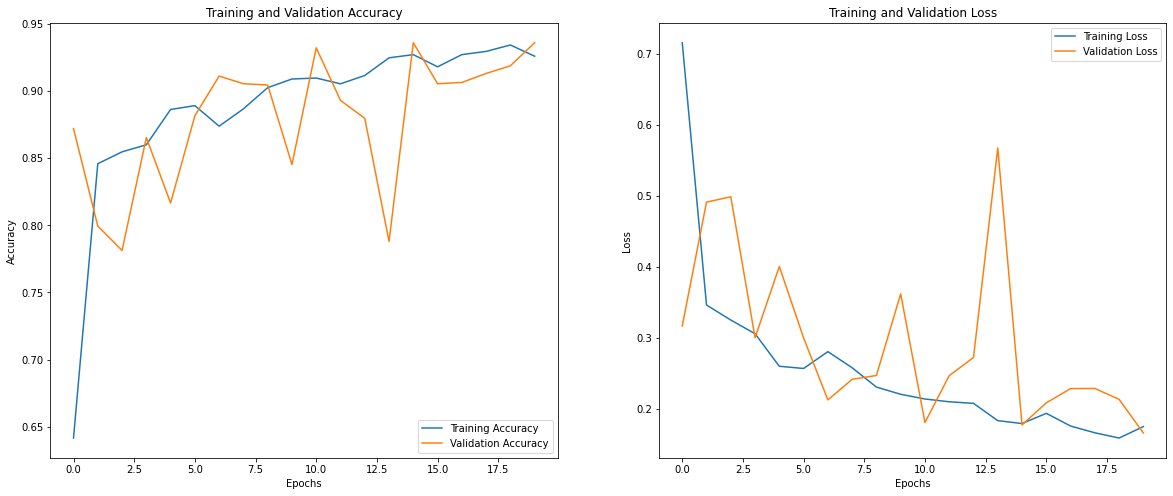

In [32]:
# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# x-axis
epochs_range = range(epochs)

# First figure: Model Accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Second figure: Model Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()